# 0. はじめに
機械学習勉強会#2でkerasの紹介用に作成しました．

例として以下のネットワークが登場します．

- image
  - MLP with MNIST
  - CNN with MNIST
  - CNN with cifiar10
  - autoencoder with MNIST
- text
  - RNN with binary classification of movie review
  - encoder-decoder (machine translation model)
  - NNLM (language model)
  - Continuous Bag-of-Words
  - Skip Gram

個別のコードについては [github](https://github.com/nzw0301/keras-examples) にあります．

## 0.1 実行環境

- python 3.5.1 (anaconda3-4.0.0)
   - keras 1.0.2
   - theano 0.8.2
   - pydot-ng 1.0.0
   - gensim 0.12.4
   - numpy 1.11.0
   - daft 0.0.4
- OSX (yosemite)
- graphviz

もし [`pyenv`](https://github.com/yyuu/pyenv) が導入済みであれば，以下のコマンドを実行して下さい．

`$ pyenv install anaconda3-4.0.0; pip install keras theano gensim pydot-ng git+https://github.com/dfm/daft.git`


## 0.2 概要

### kerasの特徴 (公式docsより)
- Modularity
- Minimalism
- Easy extensibility
- Work with Python

### そのほかkerasの特徴など

  - kerasは，tensorFlowとtheanoという既存のライブラリのラッパー
  - TFとtheanoを，そのまま使ってNNを記述するのはつらい
  - kerasでは，どちらかをbackendとして利用
  - CNNを使う場合は[TensorFlowのほうが速い](https://github.com/fchollet/keras/wiki/Keras,-now-running-on-TensorFlow#performance)
  - TFやtheanoやchainerは，変数を専用のインスタンスに変換する必要があるが，kerasではそれを行う必要がない
  - コミュニティの規模も大きめ https://twitter.com/fchollet/status/720639335524007937

In [1]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
%matplotlib inline
plt.style.use("ggplot")

import daft
from gensim.models.doc2vec import Word2Vec
import json
from IPython.display import SVG, display
import numpy as np
np.random.seed(13)

from keras import backend as K
from keras.models import Model, Sequential, model_from_json
from keras.datasets import mnist, cifar10, imdb
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM, GRU, Input, RepeatVector, TimeDistributed, Merge, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter

Using Theano backend.


In [2]:
# visualization
def draw_digit(data, row, col, n):
    plt.subplot(row, col, n)    
    plt.imshow(data)
    plt.gray()

# 1. MLP with MNIST

- MNIST（0~9の手書き文字）を使用
- 隠れ層1層の多層パーセプトロン
- 層の記述方法について言及

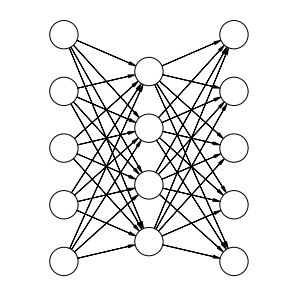

In [3]:
pgm = daft.PGM(shape=[5, 5])

# Nodes
for i in range(5):
    pgm.add_node(daft.Node("x"+str(i), "", 1, i+0.5))

for h in range(4):
    pgm.add_node(daft.Node("h"+str(h), "", 2.5, h+0.85))

for o in range(5):
    pgm.add_node(daft.Node("o"+str(o), "", 4.0, o+0.5))

# Edges
for i in range(5):
    for h in range(4):
        pgm.add_edge("x"+str(i), "h"+str(h))

for h in range(4):
    for o in range(5):
        pgm.add_edge("h"+str(h), "o"+str(o))

        
pgm.render()

## 1.1 データ

kerasの関数でダウンロードしたデータセットは `~/.keras/datasets/` 直下に配置されます．  
これによって繰り返しダウンロードする必要がなくなります．  
また，`MNIST`や`CIFAR10`のようなデータセットについては，あらかじめ関数が用意されています．

In [4]:
# データ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

nb_classes = 10 # class size
input_unit_size = 28*28 # input vector size

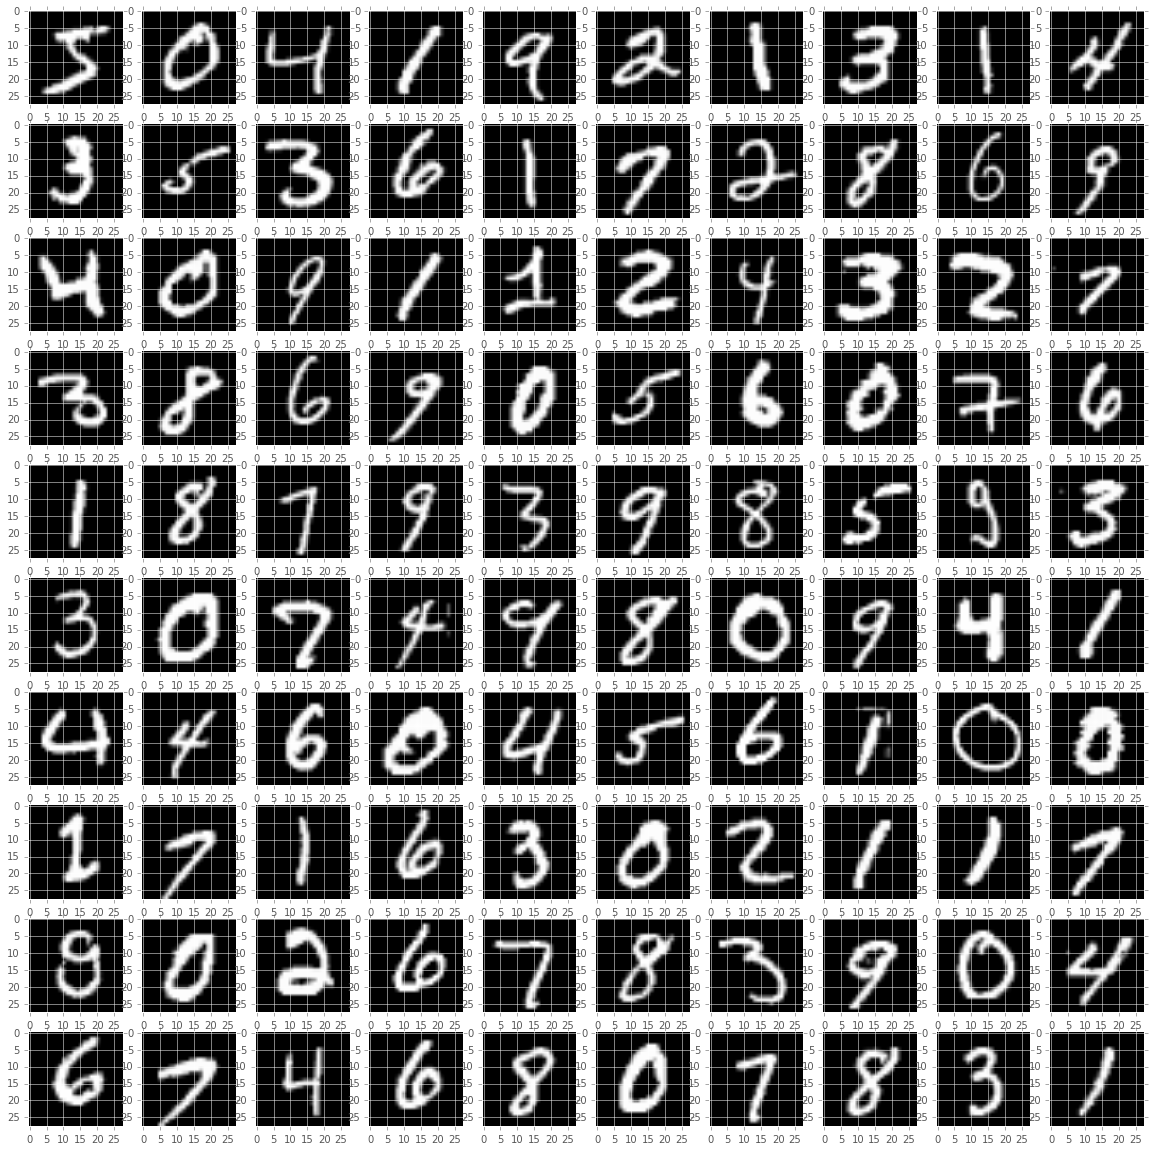

In [5]:
show_size = 10
total = 0
plt.figure(figsize=(20,20))
for i in range(show_size):
    for j in range(show_size):        
        draw_digit(X_train[total], show_size, show_size, total+1)
        total+=1
plt.show()

In [6]:
# 前処理
X_train = X_train.reshape(X_train.shape[0], input_unit_size)
X_test  = X_test.reshape(X_test.shape[0], input_unit_size)
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255
X_test  /= 255

# one-hot representation
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 784)
60000 train samples
10000 test samples


## 1.2 モデル定義

kerasでは2通りのモデルの記述方法があります．

- `Sequential`: 単純に入力層から出力層に向かって順番に層を追加してモデルを記述
- `FunctionalAPI`: `Sequential`では記述できないような複雑なモデルを記述

今回やるようなMNISTであれば前者で十分です．

この例であれば，
- 入力層784次元
- 中間層128次元
- 中間層の活性化関数が`reLU`関数
- 2割のユニットをDropout
- 出力層10次元
- 出力層の活性化関数が`softmax`関数

を記述します．

### 1.2.1 Sequentialの書き方

- `Sequential`を用意
- `add`で中間層や活性化関数を追加
- `Dropout`も同じように`add`で追加

In [7]:
model = Sequential()
model.add(Dense(128, input_dim=input_unit_size, init='glorot_uniform'))
model.add(Activation("relu"))
model.add(Dropout(p=0.2))
model.add(Dense(nb_classes, init='glorot_uniform'))
model.add(Activation('softmax'))

### 1.2.2 FunctinalAPIの書き方

- 入力データを受け取る`inputs`と，層の関数を繋げて目的値を得る`outputs`までを定義
- `Model`に`inputs`と`outputs`を渡す

In [8]:
inputs = Input(shape=(input_unit_size,))
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.2)(x)
outputs = Dense(nb_classes, activation="softmax")(x)
model = Model(input=inputs, output=outputs)

### 1.2.3 モデル可視化

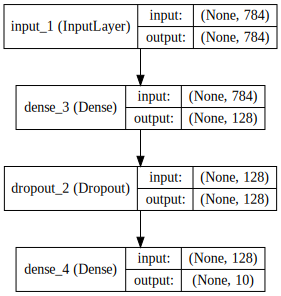

In [9]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 1.3 最適化

`SGD`のほかにも`AdaDelta`などがあります．

デフォルトのパラメータだけ指定する場合は，省略可

In [10]:
optimizer = Adadelta()

## 1.4 学習

モデルの記述と最適化の定義が終わったら，モデルのコンパイルを行います．

`compile`関数でロス関数，最適化関数，評価尺度などを指定します．

学習はバッチ処理など，複数の学習方法があります．  
もっと単純な`fit`では`scikit-learn`風に学習データを渡すだけで学習が進みます．

便利機能として学習経過を表示してくれます．

In [11]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
nb_epoch = 5

# 学習
result = model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=256, verbose=2,  validation_split=0.2)

# テストデータでの予測
score = model.evaluate(X_test, Y_test, batch_size=256)
print("test loss:", score[0])
print("test accu:", score[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
1s - loss: 0.4428 - acc: 0.8696 - val_loss: 0.2045 - val_acc: 0.9447
Epoch 2/5
1s - loss: 0.2092 - acc: 0.9401 - val_loss: 0.1505 - val_acc: 0.9560
Epoch 3/5
1s - loss: 0.1609 - acc: 0.9523 - val_loss: 0.1259 - val_acc: 0.9637
Epoch 4/5
1s - loss: 0.1303 - acc: 0.9618 - val_loss: 0.1074 - val_acc: 0.9684
Epoch 5/5
1s - loss: 0.1129 - acc: 0.9676 - val_loss: 0.1000 - val_acc: 0.9706
10000/10000 [==============================] - 0s     
test loss: 0.0920637251928
test accu: 0.9722


## 1.5 epochごとのlossとaccuracy可視化

学習が終わると`History`オブジェクトを返します．  
モデルのパラメータのほかにepochごとのlossやaccuracyが記録されています．

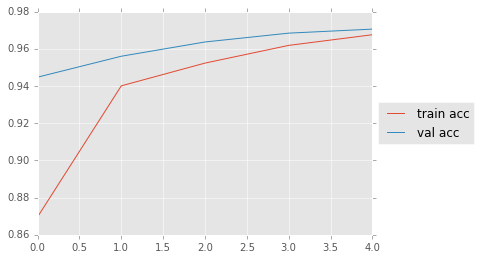

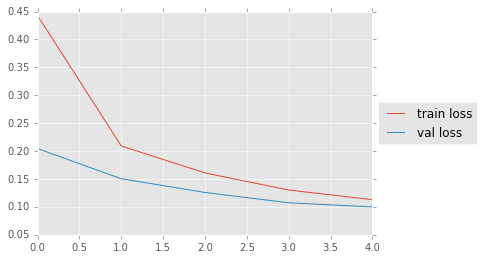

In [12]:
x = range(nb_epoch)
plt.plot(x, result.history['acc'], label="train acc")
plt.plot(x, result.history['val_acc'], label="val acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, result.history['loss'], label="train loss")
plt.plot(x, result.history['val_loss'], label="val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## 1.6 モデルの保存と読み込み
kerasのモデルファイルは`json`か`yaml`形式，
学習したモデルのパラメータは`HDF5`形式で保存・読み込み可能です．

モデルの読み込みは，以下の手順で行います．

1. モデルファイルを読み込む
2. パラメータファイルを読み込み，モデルに代入
3. `compile`

In [13]:
# save model without weights
with open('mnist_model.json', 'w') as f:
    json.dump(model.to_json(), f)
    
model.save_weights('mnist_weights.h5')

[WARNING] mnist_weights.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!


In [14]:
# load model
mnist_model = model_from_json(json.load(open("mnist_model.json")))

# load wights
mnist_model.load_weights("./mnist_weights.h5")
mnist_model.compile(loss='categorical_crossentropy', optimizer='adadelta')

## 1.7 まとめ

kerasを使ったNNの学習の流れは以下のようになります．

1. データを用意
2. model記述
3. modelコンパイル
4. training！

# 2. CNN with MNIST

画像処理で使われるCNNについてMNISTを例にして紹介します．  
MLPとほぼ同じようにモデルの記述ができます．

## 2.1 データ

CNNの入力画像は，$(channels, rows, columns)$というテンソルを使います．  
MNISTはグレースケールなので$(1, 28, 28)$となります．

In [15]:
img_rows, img_cols = 28, 28
nb_classes = 10
nb_filters = 10 # the number of filters
nb_pool = 2 # window size of pooling
nb_conv = 3 # window size of filter

# data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols) 
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


## 2.2 モデル定義
MLPと同じく畳み込み層や`pooling`層を`add`で積んでいきます．


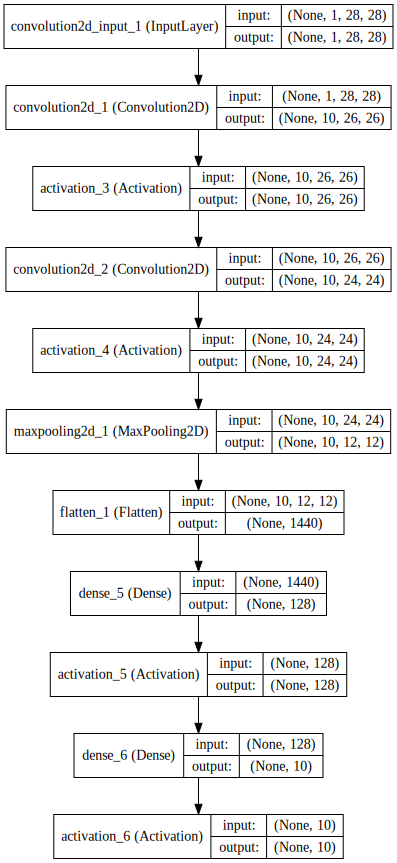

In [16]:
model = Sequential()
model.add(Convolution2D(nb_filters, nb_conv, nb_conv, input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adadelta",
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 2.3 学習

In [17]:
nb_epoch = 5
cnn_result = model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=256, verbose=2,  validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
51s - loss: 0.2709 - acc: 0.9140 - val_loss: 0.1108 - val_acc: 0.9650
Epoch 2/5
48s - loss: 0.0687 - acc: 0.9785 - val_loss: 0.0735 - val_acc: 0.9765
Epoch 3/5
47s - loss: 0.0461 - acc: 0.9861 - val_loss: 0.0620 - val_acc: 0.9814
Epoch 4/5
47s - loss: 0.0324 - acc: 0.9902 - val_loss: 0.0593 - val_acc: 0.9840
Epoch 5/5
53s - loss: 0.0233 - acc: 0.9928 - val_loss: 0.0518 - val_acc: 0.9855


## 2.4 学習曲線の可視化
MLPの結果と比較してみましょう．

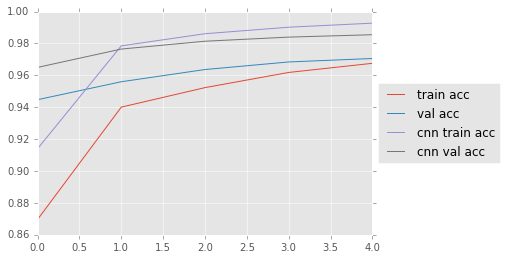

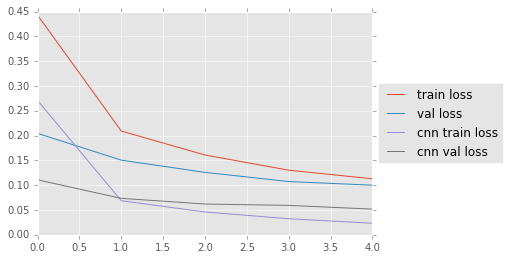

In [22]:
x = range(nb_epoch)
plt.plot(x, result.history['acc'], label="train acc")
plt.plot(x, result.history['val_acc'], label="val acc")
plt.plot(x, cnn_result.history['acc'], label="cnn train acc")
plt.plot(x, cnn_result.history['val_acc'], label="cnn val acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, result.history['loss'], label="train loss")
plt.plot(x, result.history['val_loss'], label="val loss")
plt.plot(x, cnn_result.history['loss'], label="cnn train loss")
plt.plot(x, cnn_result.history['val_loss'], label="cnn val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 2.5 中間層の可視化
kerasでは，定義したモデルの各層の入出力を関数として扱えます．  
それを用いて，MNISTの入力画像に対して中間層がどのような画像に変換されているかを可視化します．

In [18]:
model.layers

### 2.5.1元画像

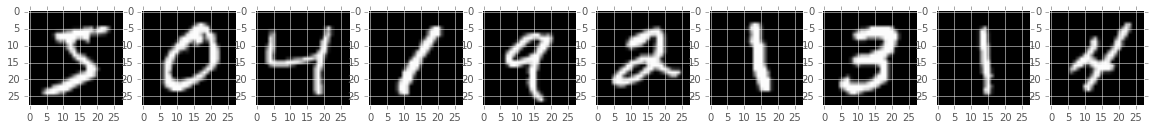

In [19]:
show_size = 10
plt.figure(figsize=(20,20))

for i in range(show_size):
    draw_digit(X_train[i].reshape(28,28), 1, show_size, i+1)
plt.show()

### 2.5.2 中間層
最初の畳み込み層に`relu`を通した画像の可視化

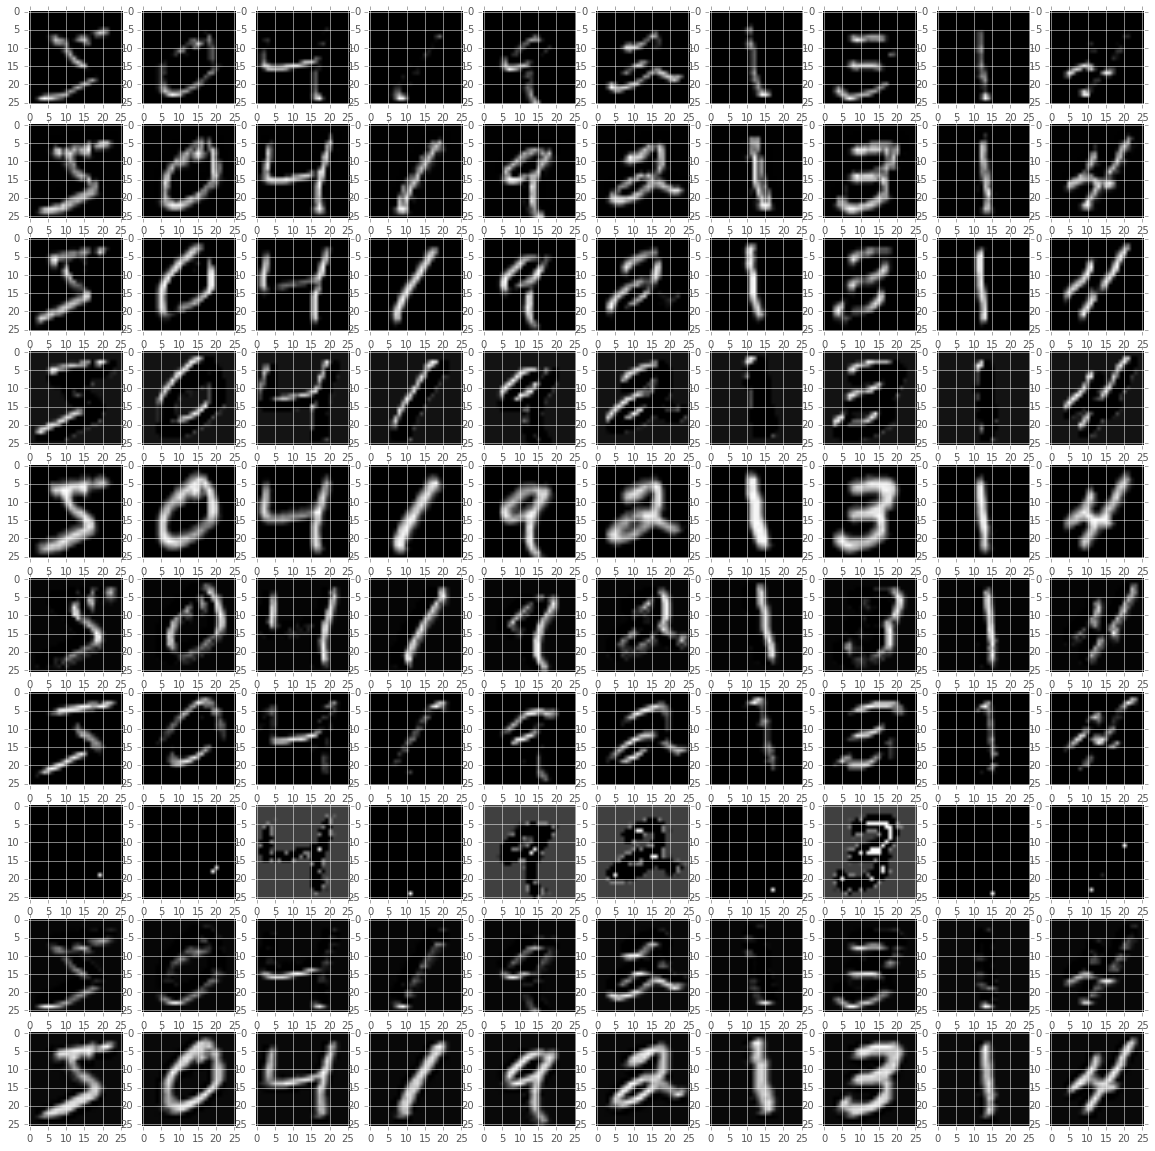

In [23]:
get_first_layer_output = K.function([model.layers[0].input],
                                    [model.layers[1].output])
first_layer = get_first_layer_output([X_train[0:show_size]])[0]

plt.figure(figsize=(20,20))

for img_index, filters in enumerate(first_layer, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*10+img_index
        draw_digit(mat, nb_filters, show_size, pos)
plt.show()

### 2.5.3 中間層
2つ目の畳み込み層に`relu`を通した画像の可視化

(10, 10, 24, 24)


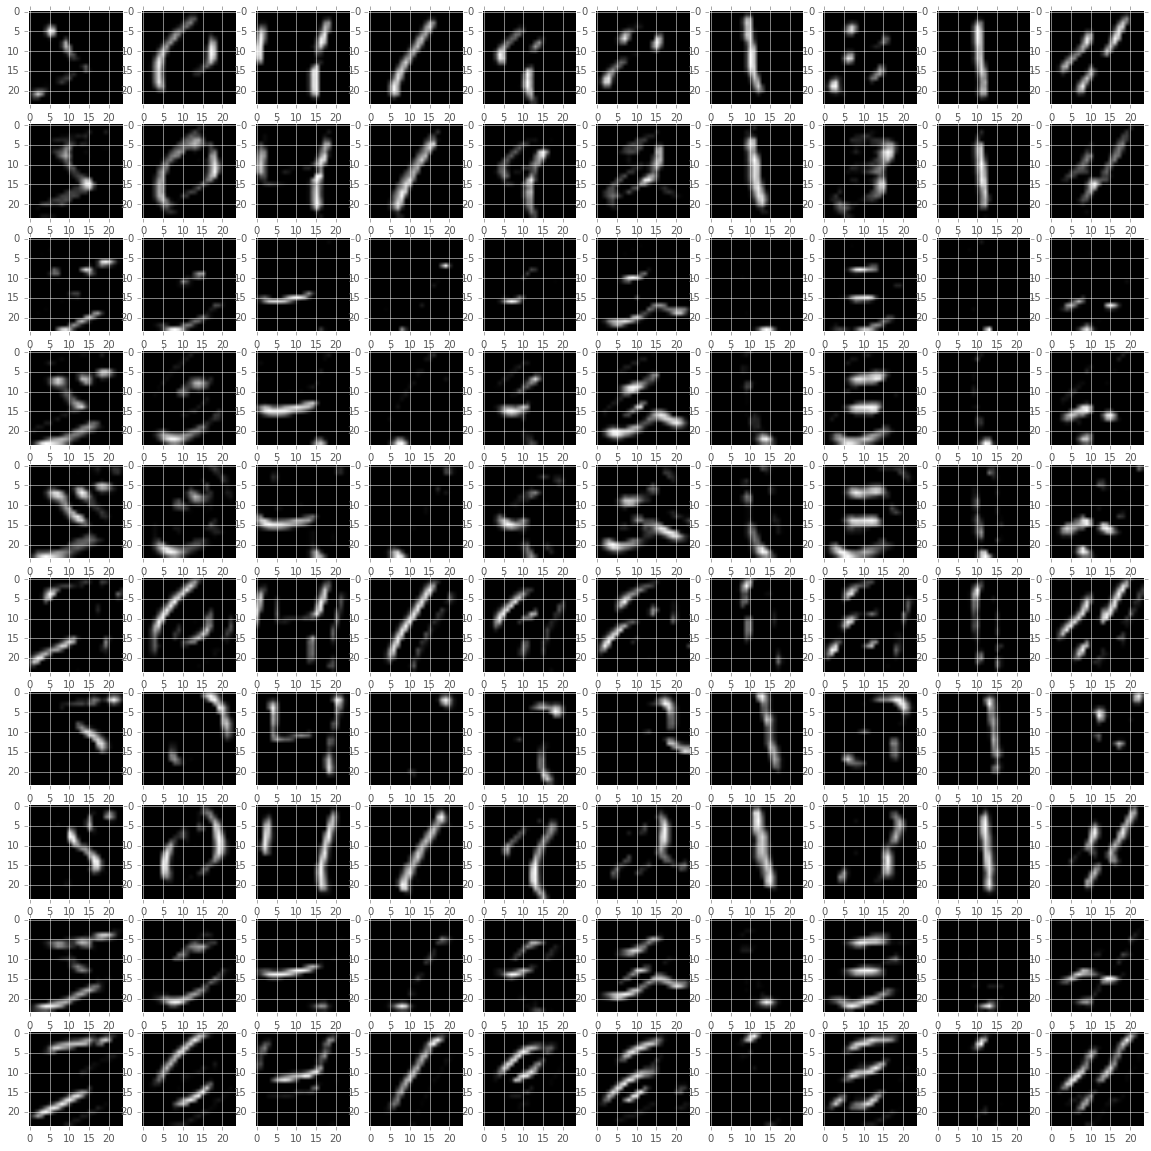

In [20]:
get_second_layer_output = K.function([model.layers[0].input],
                                  [model.layers[3].output])
second_output = get_second_layer_output([X_train[0:show_size]])[0]

show_size = 10
plt.figure(figsize=(20,20))
print(second_output.shape)

for img_index, filters in enumerate(second_output, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*10+img_index
        draw_digit(mat, nb_filters, show_size, pos)
plt.show()

### 2.5.4 pooling層
`maxpooling`を通した画像の可視化

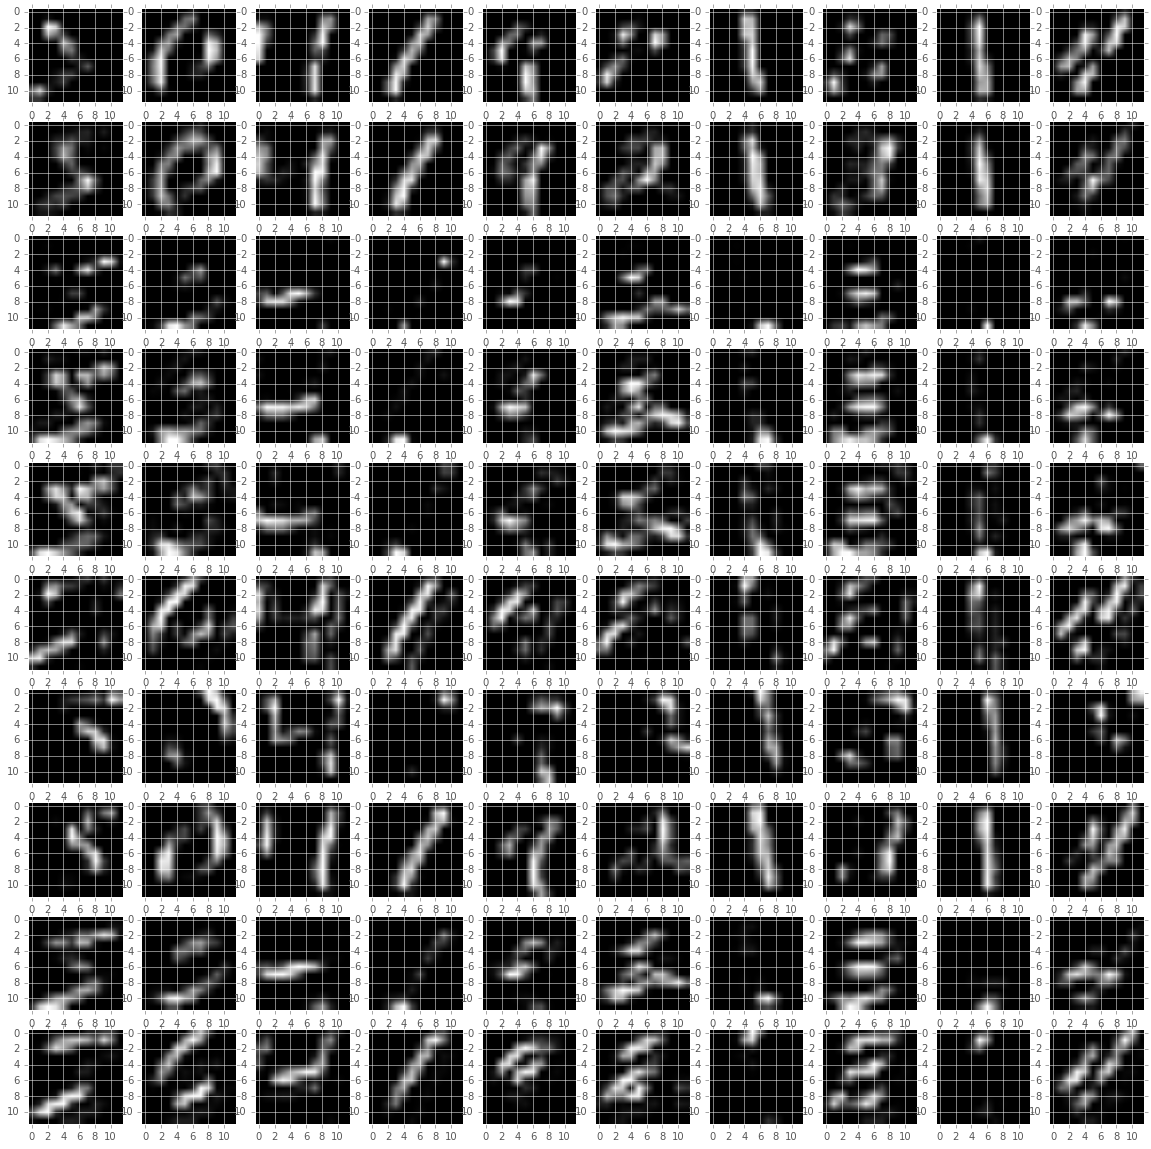

In [24]:
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[4].output])
layers = get_3rd_layer_output([X_train[0:show_size]])[0]

show_size = 10
plt.figure(figsize=(20,20))

for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*10+img_index
        draw_digit(mat, nb_filters, show_size, pos)
plt.show()

# 3. CNN with CIFAR10
今度はカラー画像を使ったCNNを扱います．  
$(channels=3, rows=32, columns=32)$というテンソルで1つの画像を表現します．

## 3.1 データ

In [25]:
batch_size = 256
nb_classes = 10
nb_epoch = 5
nb_filter = 10

img_rows, img_cols = 32, 32
img_channels = 3

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


## 3.2 モデル定義と学習

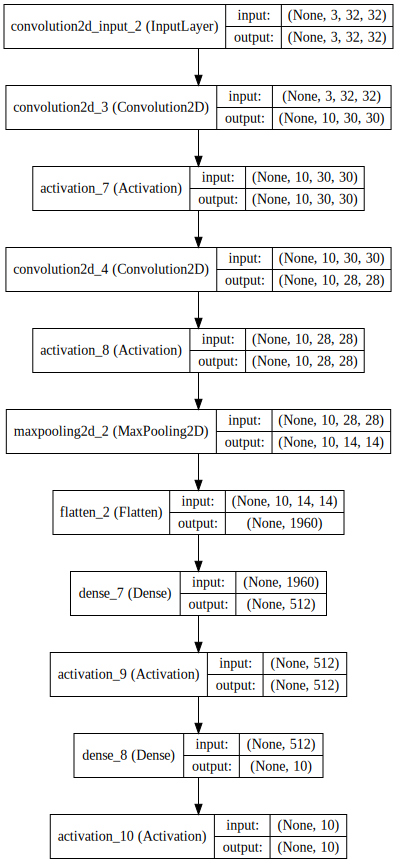

In [26]:
model = Sequential()
model.add(Convolution2D(nb_filter, 3, 3, input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filter, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [27]:
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 83s - loss: 1.7946 - acc: 0.3630 - val_loss: 1.5176 - val_acc: 0.4663
Epoch 2/5
50000/50000 [==============================] - 82s - loss: 1.3445 - acc: 0.5271 - val_loss: 1.3694 - val_acc: 0.5138
Epoch 3/5
50000/50000 [==============================] - 82s - loss: 1.1380 - acc: 0.6000 - val_loss: 1.2711 - val_acc: 0.5561
Epoch 4/5
50000/50000 [==============================] - 83s - loss: 0.9772 - acc: 0.6598 - val_loss: 1.1615 - val_acc: 0.5963
Epoch 5/5
50000/50000 [==============================] - 82s - loss: 0.8254 - acc: 0.7148 - val_loss: 1.1207 - val_acc: 0.6111


## 3.3 可視化

In [28]:
# visualization
def draw_color(data, row, col, n):
    plt.subplot(row, col, n)
    plt.imshow(data)

### 3.3.1 元画像

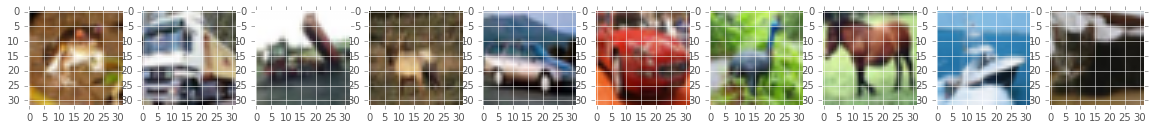

In [29]:
show_size = 10
plt.figure(figsize=(20,20))
for i in range(show_size):
    draw_color(X_train[i].reshape(3, 32, 32).transpose(1, 2, 0), 1, show_size, i+1)
plt.show()

### 3.3.2 畳み込み層+relu

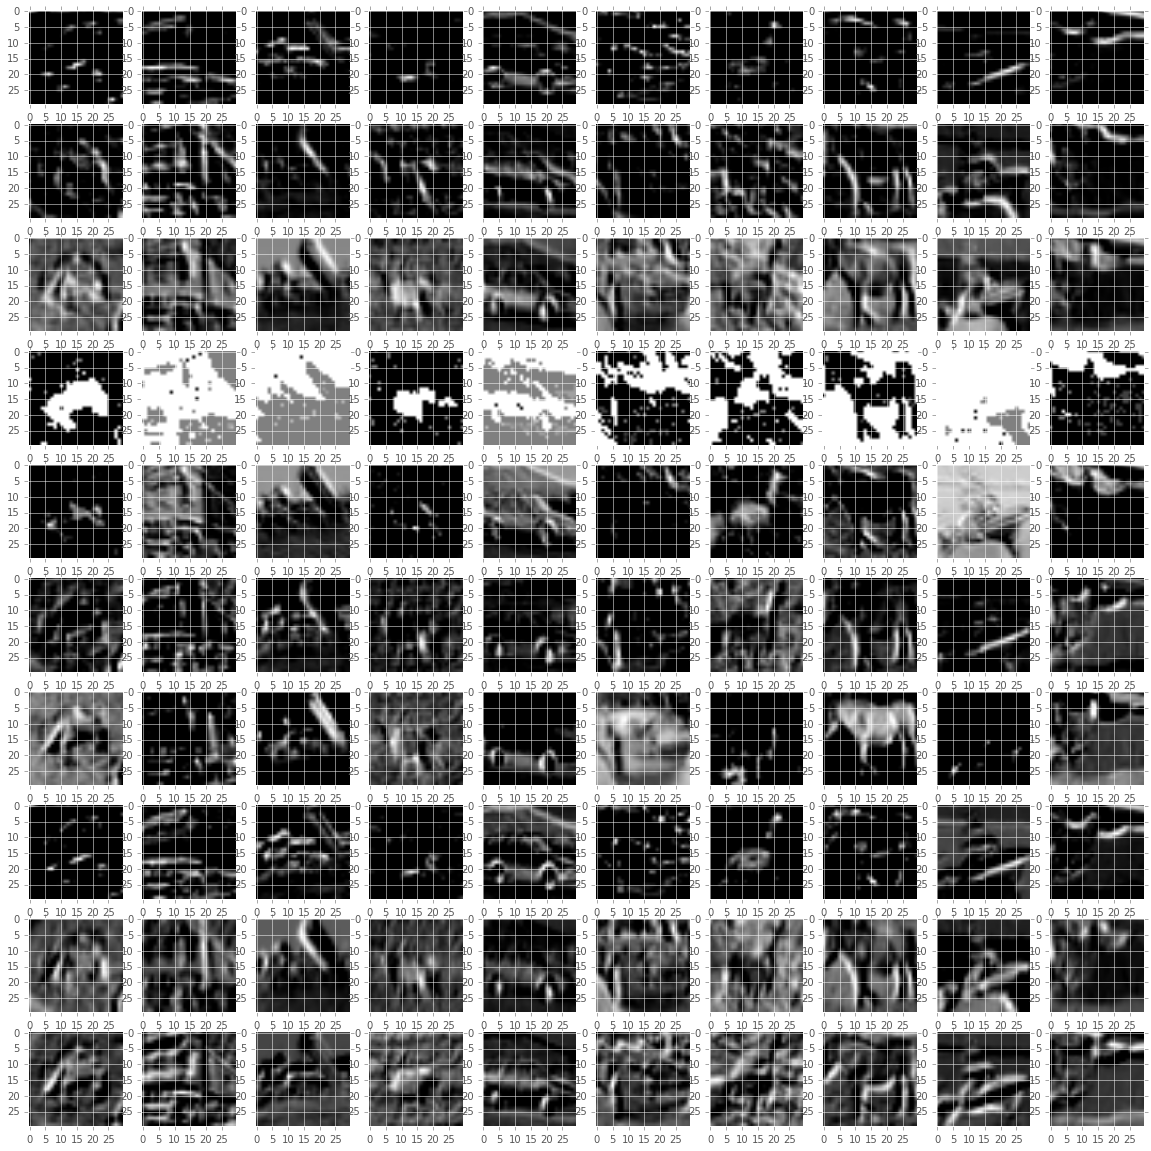

In [30]:
plt.figure(figsize=(20,20))
layer_output = K.function([model.layers[0].input],
                          [model.layers[1].output])
layers = layer_output([X_train[0:show_size]])[0]
for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*show_size+img_index
        draw_color(mat, nb_filter, show_size, pos)
plt.show()

### 3.3.3 畳み込み層+relu+畳み込み層+relu

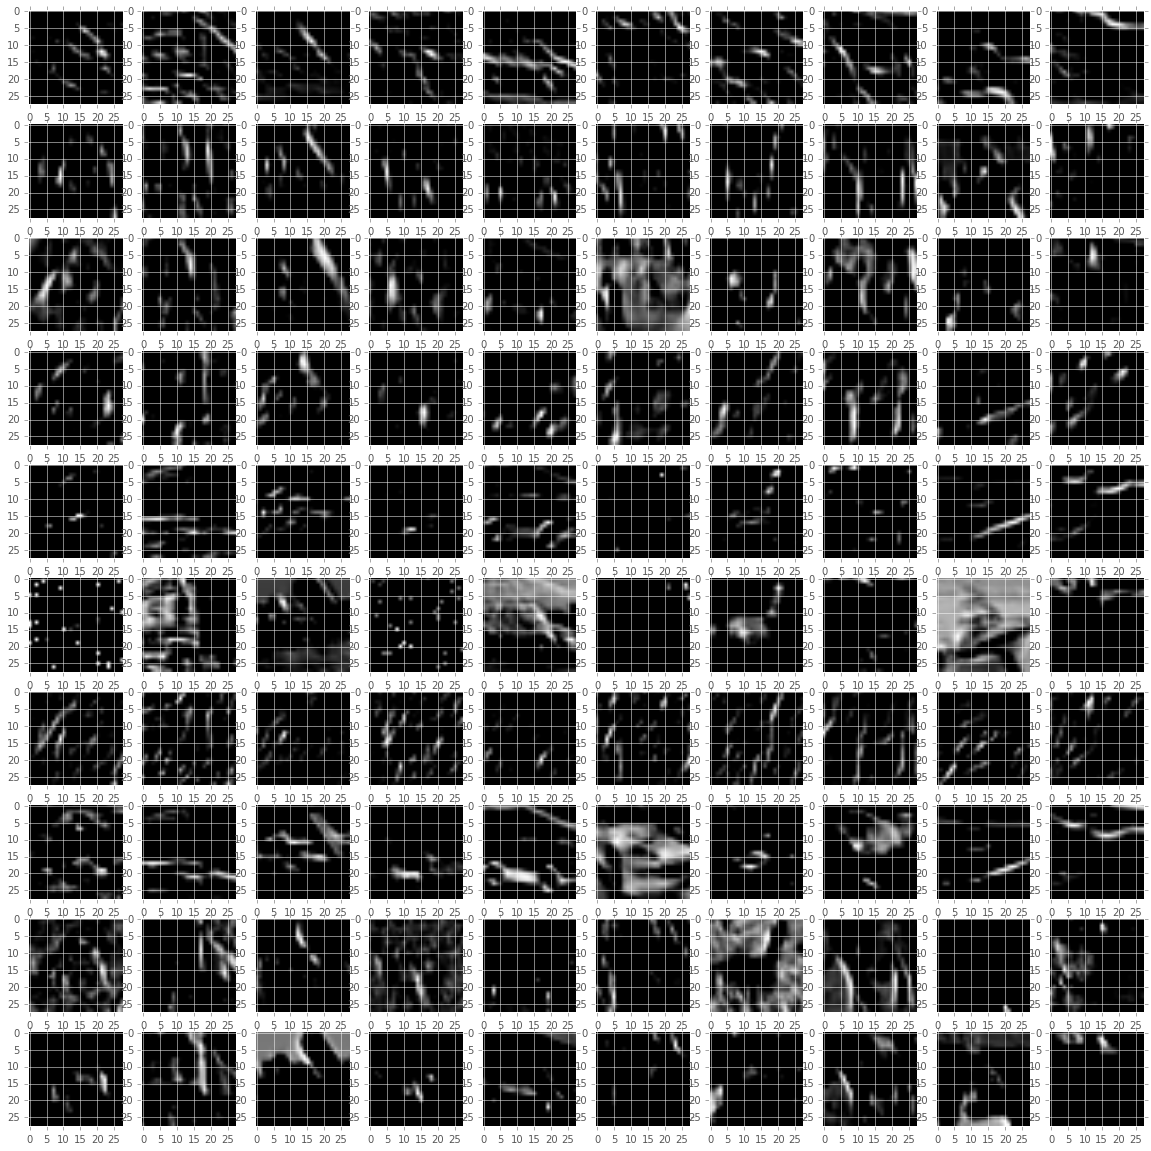

In [31]:
plt.figure(figsize=(20,20))

layer_output = K.function([model.layers[0].input],
                          [model.layers[3].output])

layers = layer_output([X_train[0:show_size]])[0]

for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*show_size+img_index
        draw_color(mat, nb_filter, show_size, pos)
plt.show()

### 3.3.4 畳み込み層+relu+畳み込み層+relu+maxPooling

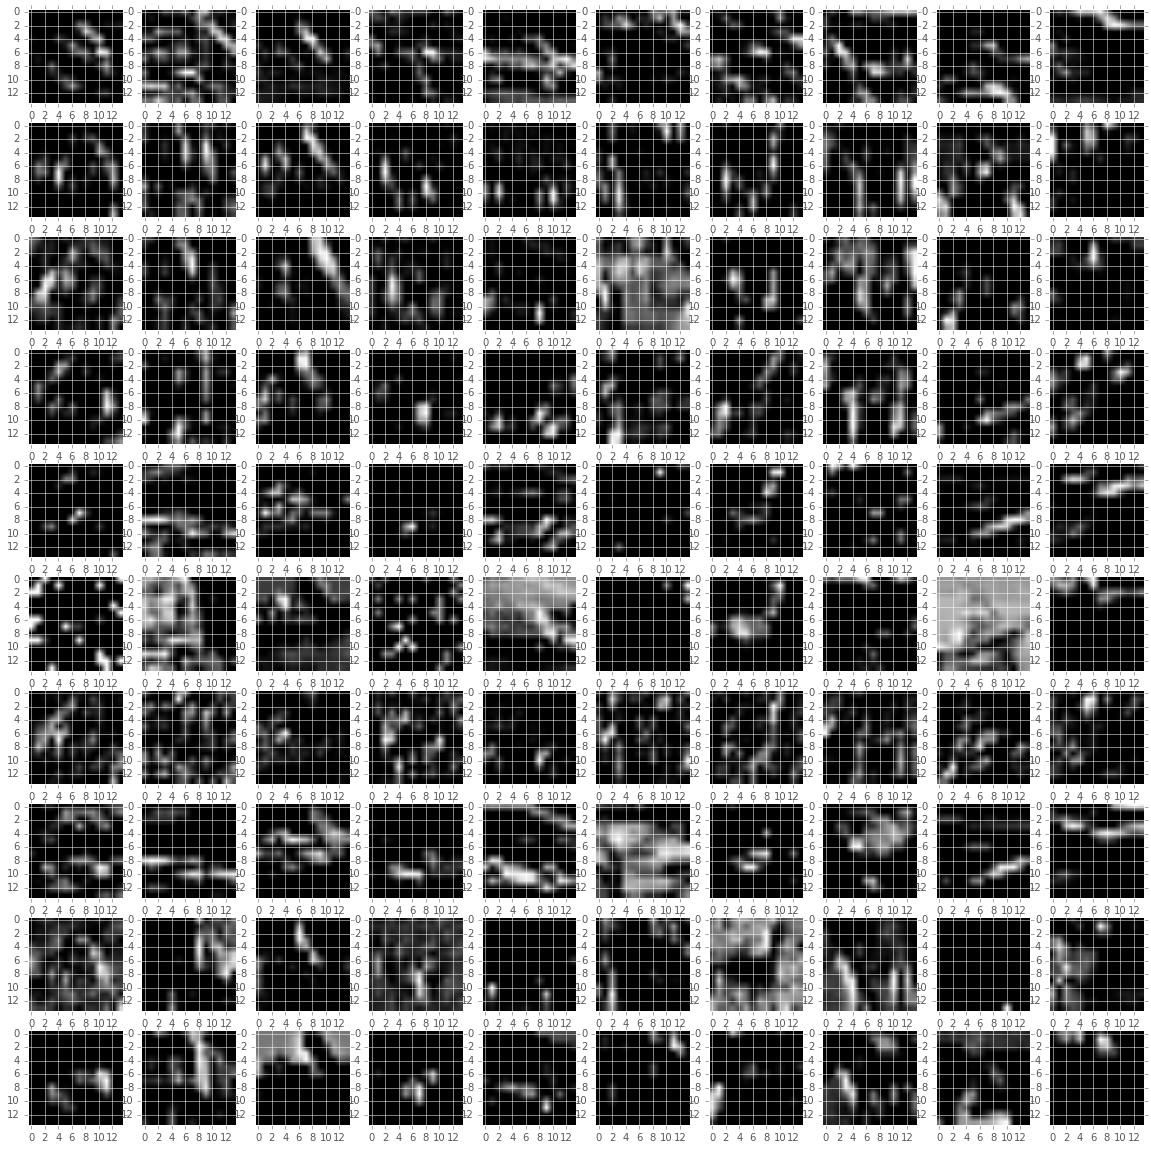

In [32]:
plt.figure(figsize=(20,20))
layer_output = K.function([model.layers[0].input],
                          [model.layers[4].output])
layers = layer_output([X_train[0:show_size]])[0]


for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*show_size+img_index
        mat_size = mat.shape[1]
        draw_color(mat, nb_filter, show_size, pos)
plt.show()

# 4. RNN with binary classification

言語処理や音声など時系列データに使われるNNです．  
`Embeddings`と`RNN`について触れます．

## 4.1 データ

映画のレビューデータを扱います．  
入力が単語系列，出力が0か1の2値です．  
特徴量として頻出語20,000単語だけを使い，1レビューは最長140単語とします．  
このような前処理もkerasの関数に用意されています．

In [33]:
max_features = 20000
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features)
maxlen=140
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
nb_epoch = 3

## 4.2 モデル定義

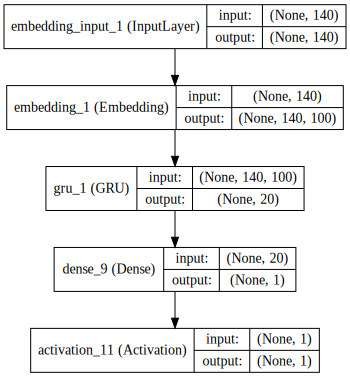

In [34]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=100, init='glorot_uniform', input_length=maxlen))
model.add(GRU(20, return_sequences=False))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 4.2.1 Embedding layer

1つの整数（例えば単語を数値に変化したもの）を1つのベクトルに対応づける層です．  
上で定義したものは最大で140単語が含まれる文を入力し，それぞれの単語を100次元の単語ベクトルに変換します．  
1単語が100次元でそれが最長140系列，それがデータ数だけあるという状態に対応します．

In [35]:
x = X_train[0:2]
print("Inputs shape", x.shape)

embedding_layer = K.function([model.layers[0].input],[model.layers[0].output])
print("Outputs shape", embedding_layer([x])[0].shape)

Inputs shape (2, 140)
Outputs shape (2, 140, 100)


### 4.2.2 RNN  layer


kerasの`RNN`層は3種類用意されています．

- `SimpleRNN`
- `GRU`
- `LSTM`

テンソル（さっきの`Embedding`層を通した結果のデータと同じ次元を持つデータ）を入力とし，
行列かテンソルを出力します．

- 次の層もRNNであれば各時刻ごとに処理する必要があるので，テンソル
- 次の層が出力層や固定長ベクトルを構築する場合，最後の時刻のRNNの出力さえあればいいので，行列

という使い分けができるかと思います．  
コードレベルでいうと  
`RNN(return_sequences=True)`が前者，
`RNN(return_sequences=False)`が後者に対応します．

In [36]:
res_gru_1 = model.fit(X_train, y_train, batch_size=256, nb_epoch=nb_epoch, validation_data=(X_test, y_test))

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 41s - loss: 0.6872 - acc: 0.5467 - val_loss: 0.6908 - val_acc: 0.5078
Epoch 2/3
20000/20000 [==============================] - 40s - loss: 0.6574 - acc: 0.6064 - val_loss: 0.6790 - val_acc: 0.5682
Epoch 3/3
20000/20000 [==============================] - 41s - loss: 0.6103 - acc: 0.6783 - val_loss: 0.7436 - val_acc: 0.5790


### 4.2.3 more RNN
`GRU`と`LSTM`を比較します．

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 76s - loss: 0.6862 - acc: 0.5427 - val_loss: 0.6611 - val_acc: 0.6084
Epoch 2/3
20000/20000 [==============================] - 76s - loss: 0.6446 - acc: 0.6205 - val_loss: 0.5929 - val_acc: 0.6686
Epoch 3/3
20000/20000 [==============================] - 75s - loss: 0.5955 - acc: 0.6797 - val_loss: 0.6935 - val_acc: 0.5938


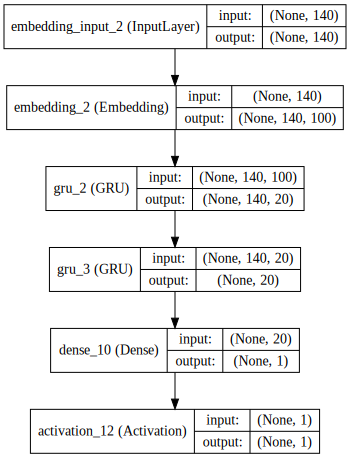

In [37]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=100, init='glorot_uniform', input_length=maxlen))
model.add(GRU(20, return_sequences=True))
model.add(GRU(20, return_sequences=False))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

res_gru_2 = model.fit(X_train, y_train, batch_size=256, nb_epoch=nb_epoch, validation_data=(X_test, y_test))

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 57s - loss: 0.6841 - acc: 0.5578 - val_loss: 0.6312 - val_acc: 0.6674
Epoch 2/3
20000/20000 [==============================] - 55s - loss: 0.6356 - acc: 0.6504 - val_loss: 0.5661 - val_acc: 0.7092
Epoch 3/3
20000/20000 [==============================] - 57s - loss: 0.5829 - acc: 0.6986 - val_loss: 0.5400 - val_acc: 0.7276


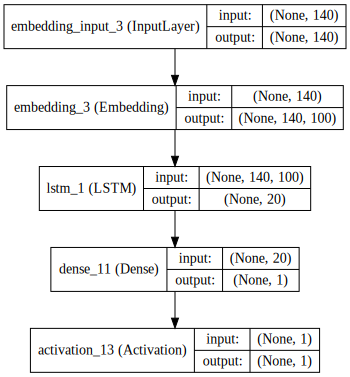

In [38]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=100, init='glorot_uniform', input_length=maxlen))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

res_lstm_1 = model.fit(X_train, y_train, batch_size=256, nb_epoch=nb_epoch,
                    validation_data=(X_test, y_test))

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 4.3 可視化

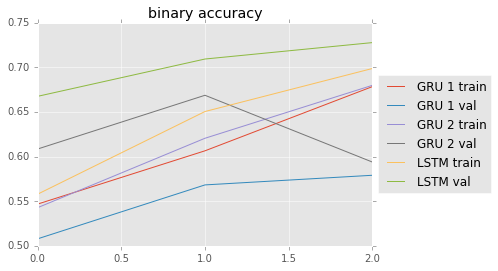

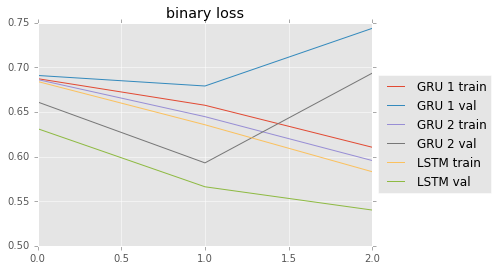

In [39]:
x = range(nb_epoch)
plt.plot(x, res_gru_1.history['acc'], label="GRU 1 train")
plt.plot(x, res_gru_1.history['val_acc'], label="GRU 1 val")
plt.plot(x, res_gru_2.history['acc'], label="GRU 2 train")
plt.plot(x, res_gru_2.history['val_acc'], label="GRU 2 val")
plt.plot(x, res_lstm_1.history['acc'], label="LSTM train")
plt.plot(x, res_lstm_1.history['val_acc'], label="LSTM val")
plt.title("binary accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, res_gru_1.history['loss'], label="GRU 1 train")
plt.plot(x, res_gru_1.history['val_loss'], label="GRU 1 val")
plt.plot(x, res_gru_2.history['loss'], label="GRU 2 train")
plt.plot(x, res_gru_2.history['val_loss'], label="GRU 2 val")
plt.plot(x, res_lstm_1.history['loss'], label="LSTM train")
plt.plot(x, res_lstm_1.history['val_loss'], label="LSTM val")
plt.title("binary loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 5. Neural Network Language Models

Markov modelsでやるような，前の単語系列から次の単語系列を予測を行います．

## 5.1 データ
_Alice's Adventures in Wonderland_ の一部を使います．  
`get_file` では指定したURLのファイルを `~/.keras/datasets/`以下に保存できます．

`Tokenizer`はテキストデータの前処理を行う便利クラスで，単語系列を数値の系列に変換します．

In [40]:
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
doc = open(path).readlines()[0:50]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(doc)
doc = tokenizer.texts_to_sequences(doc)
doc = [l for l in doc if len(l) > 1]
words_size = sum([len(words) - 1 for words in doc])

maxlen = max([len(x)-1 for x in doc])
vocab_size = len(tokenizer.word_index)+1

## 5.2 学習方法の工夫

前の系列から次の1単語を予測するように学習

1. _alice's_ -> _Adventures_
2. _alice's Adventures_ -> _in_
3.  _alice's Adventures in_ -> _..._

真面目にこのデータを作るとメモリ不足になるのでpythonの `generator` を使います．  
kerasでは`generator`を引数にとって学習することも可能であるが，nzwの環境ではうまくいかなかったので，
ここでは，文単位で学習データをつくり，`train_on_batch`関数で学習を行います．

In [47]:
def generate_data(X, maxlen, V):
    for sentence in X: 
        inputs = []
        targets = []
        for i in range(1, len(sentence)):
            inputs.append(sentence[0:i])
            targets.append(sentence[i])
            y = np_utils.to_categorical(targets, V)
        inputs_sequence = sequence.pad_sequences(inputs, maxlen=maxlen)
        yield (inputs_sequence, y)


## 5.3 モデル定義

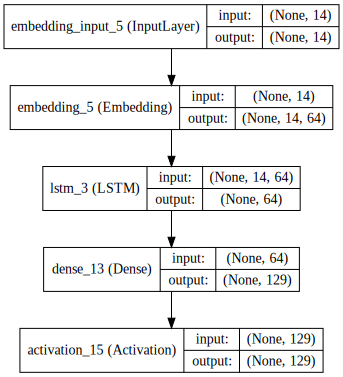

In [48]:
nb_units = 64
model = Sequential()
model.add(Embedding(vocab_size, nb_units, input_length=maxlen))
model.add(LSTM(nb_units, return_sequences=False))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 5.4 学習と文生成

### 5.4.1 サンプリング方法

1epochごとに _alice's_ を入力とし，
次の単語を予測を行い，予測した単語を_alice's_に加えて新しい文とします．  
これを最大系列長になるまで予測を繰り返し行います．

次の単語は，単語の予測分布（多項分布）に従いサンプルします．

In [49]:
def sample(p):
    p /= sum(p)
    return np.where(np.random.multinomial(1,p,1)==1)[1][0]

In [50]:
for i in range(19):
    for x, y in generate_data(doc, maxlen, vocab_size):
        model.train_on_batch(x, y)

    in_words = "alice's"
    for _ in range(maxlen):
        in_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences([in_words]), maxlen=maxlen)
        wordid = sample(model.predict(in_sequence)[0])
        for k, v in tokenizer.word_index.items():
            if v == wordid:
                in_words += " " + k
                break

    print(i, in_words)

0 alice's hot very getting chain pleasure anywhere millennium ebook very 3 a june author cost
1 alice's sister down terms 3 english ebook start very march 'without adventures it the having
2 alice's i the bank alice wonderland in or at included ' 'without hole pleasure 25
3 alice's carroll carroll it hole sitting worth the alice's sleepy or to ' release daisy
4 alice's pictures wonderland ebook ' tired into carroll ' license the edition in she '
5 alice's the her march what carroll and 2011 stupid this worth millennium lewis down adventures
6 alice's 'and use in whether hole of pleasure chapter had alice's or alice 0 sitting
7 alice's for for carroll or what pictures 'without edition adventures a 0 once 1994 hole
8 alice's march carroll rabbit edition very pictures date wonderland would book beginning ﻿project english her
9 alice's her use millennium and mind made worth lewis twice 11 of march could alice's
10 alice's project alice day anyone give carroll carroll is gutenberg's up made

### 5.4.2 最尤推定

確率値最大となる単語を連結し，文生成を行います．

In [51]:
in_words = "alice's"
for _ in range(maxlen):
    in_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences([in_words]), maxlen=maxlen)
    wordid = model.predict_classes(in_sequence, verbose=0)[0]
    for k, v in tokenizer.word_index.items():
        if v == wordid:
            in_words += " " + k
            break

print(in_words)

alice's adventures in wonderland carroll carroll carroll carroll carroll carroll the of of of of


# 6. encoder-decoder

先ほどと類似したものとして，今度は入力系列を日本語，出力系列を英語とした翻訳を行うモデルです．  
（kerasのサンプルでは，画像を入力としその説明文を出力するようなNNがあります）

## 6.1 データ
対訳コーパスや発言に対する返答など行対応のとれているファイルが必要になります．  
ここでは _The Yellow Face_ の日英の文書を，[ここ](http://www2.nict.go.jp/univ-com/multi_trans/member/mutiyama/align/index.html) から持ってきてその一部を使います．  
日本語については形態素解析済みとします．  
翻訳先の文に対して，文の始まりを表す記号`GOS`，文末を表す記号`EOS`を追加して学習データを作ります．

In [52]:
filters = base_filter() + "「」・。、（）？！　'"

In [58]:
# ja data
ja_docs = open("data/yellow.ja.txt").readlines()[0:50]
ja_tokenizer = Tokenizer(filters=filters)
ja_tokenizer.fit_on_texts(ja_docs)

ja_docs = ja_tokenizer.texts_to_sequences(ja_docs)

# en data
en_docs = open("data/yellow.en.txt").readlines()
en_docs = list(map(lambda x: "GOS " + x + " EOS" , en_docs))[0:50]
en_tokenizer = Tokenizer(filters=filters)
en_tokenizer.fit_on_texts(en_docs)
en_tokenizer.fit_on_texts(en_docs)

en_docs = en_tokenizer.texts_to_sequences(en_docs)

encoder_maxlen = max([len(x) for x in ja_docs])
decoder_maxlen = max([len(x)-1 for x in en_docs])
encoder_vocab_size = len(ja_tokenizer.word_index)+1
decoder_vocab_size = len(en_tokenizer.word_index)+1

## 6.2 バッチ処理を行うための関数定義

In [59]:
def gen_training_data(X, Y, encoder_maxlen, decoder_maxlen, V, samples_size):
    encoder_inputs = []
    decoder_inputs = []
    next_words = []
    for i in range(len(X)):
        x_doc, y_doc = X[i], Y[i]
        for j in range(1, len(y_doc)):
            decoder_inputs.append(y_doc[0:j])
            next_words.append(y_doc[j])
            encoder_inputs.append(x_doc)
            if len(next_words) == samples_size:                
                labels = np_utils.to_categorical(next_words, V)
                encoder_inputs = sequence.pad_sequences(encoder_inputs, maxlen=encoder_maxlen)
                decoder_inputs = sequence.pad_sequences(decoder_inputs, maxlen=decoder_maxlen)
                yield ([encoder_inputs, decoder_inputs], labels)
                encoder_inputs = []
                decoder_inputs = []
                next_words = []
    labels = np_utils.to_categorical(next_words, V)
    encoder_inputs = sequence.pad_sequences(encoder_inputs, maxlen=encoder_maxlen)
    decoder_inputs = sequence.pad_sequences(decoder_inputs, maxlen=decoder_maxlen)

    yield ([encoder_inputs, decoder_inputs], labels)

## 6.3 モデル定義
独立した`Sequential`を結合して新しい`Sequential`を構築できます．  
定義するモデルは，基本的にNNLMと同じで1つ先の単語列を予測を行うようなNNです．

- 翻訳元の言語の文から1つの中間ベクトルを出力する`encoder`
- 翻訳先の予測する1単語目から`N-1`単語目までの単語を入力として受け取る`decoder_input`
- `encoder`と`decoder_input`を結合して，1つの単語を予測を行う`model`

の3つから構成される．


In [60]:
# encoder one doc to one repeated vector
encoder = Sequential()
encoder.add(Embedding(encoder_vocab_size, 128, input_length=encoder_maxlen))
encoder.add(GRU(128, return_sequences=False))
encoder.add(RepeatVector(decoder_maxlen))

# decoder inputs
decoder_input = Sequential()
decoder_input.add(Embedding(decoder_vocab_size, 128, input_length=decoder_maxlen))
decoder_input.add(GRU(output_dim=128, return_sequences=True))
decoder_input.add(TimeDistributed(Dense(128)))

model = Sequential()
model.add(Merge([encoder, decoder_input], mode='concat', concat_axis=-1))
model.add(GRU(128, return_sequences=False))
model.add(Dense(decoder_vocab_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta')

with open('my_model.json', 'w') as f:
    json.dump(model.to_json(), f)


encoder


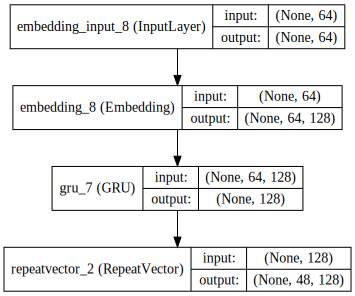

decoder input


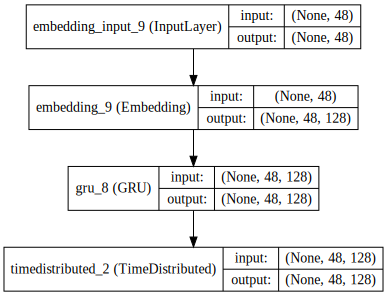

merge and decoder output


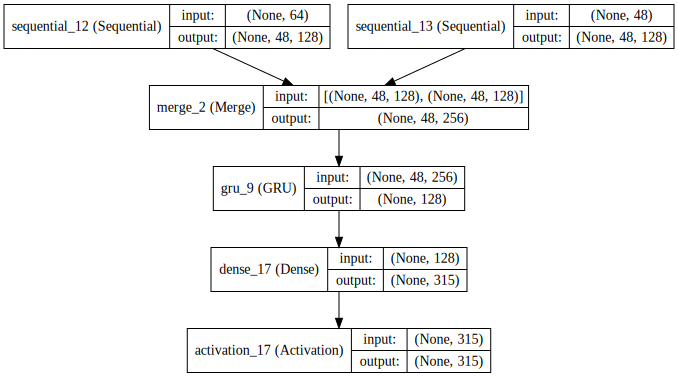

In [61]:
print("encoder")
display(SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg')))
print("decoder input")
display(SVG(model_to_dot(decoder_input, show_shapes=True).create(prog='dot', format='svg')))
print("merge and decoder output")
display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

## 6.4 学習

In [62]:
for i in range(21):
        loss = 0.
        for x, y in gen_training_data(ja_docs, en_docs, encoder_maxlen, decoder_maxlen, decoder_vocab_size, 256):
            loss += model.train_on_batch(x, y)
        print(i, "loss ", loss)
        if not i % 10:
            model.save_weights('my_model_weights_' + str(i) + '.h5')

0 loss  17.2141909599
1 loss  16.9887566566
2 loss  16.2411899567
3 loss  15.7206983566
4 loss  15.5117740631
5 loss  15.4506354332
6 loss  15.4058394432
7 loss  15.3756952286
8 loss  15.34709692
9 loss  15.3168869019
10 loss  15.2805161476
11 loss  15.2358422279
12 loss  15.1841897964
13 loss  15.1340575218
14 loss  15.0821118355
15 loss  15.0178146362
16 loss  14.9242806435
17 loss  14.8268032074
18 loss  14.7436642647
19 loss  14.6707334518
20 loss  14.6044588089


## 6.5 翻訳

In [63]:
# load model
model = model_from_json(json.load(open("my_model.json")))

In [64]:
encoder_words = "ホームズ は 答え た"
encoder_in = sequence.pad_sequences(ja_tokenizer.texts_to_sequences([encoder_words]), maxlen=encoder_maxlen)

for i in range(0, 21, 10):
    model.load_weights("./my_model_weights_" + str(i) + ".h5")
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')

    decoder_words = "gos"
    for _ in range(encoder_maxlen):
        decoder_in = sequence.pad_sequences(en_tokenizer.texts_to_sequences([decoder_words]),  maxlen=decoder_maxlen)
        wordid = sample(model.predict([encoder_in, decoder_in])[0])
        
        for k, v in en_tokenizer.word_index.items():
            if v == wordid:
                decoder_words += " " + k
                break
        if k == "eos":
            break

    print(i, decoder_words.replace("gos", "").replace("eos", ""))

0  notes had the did else looks finest these good erred could together save silence gone i strange circumstances the didn watson chanced he breaking capable doyle never his faint relaxed cries habits rather just i kept walks outs importance failures erred forever to breaking ll those into did badly hours passage man versatility beginning gifts burst you for rather strange doyle undoubtedly tale each
10  he holmes elms we in face short no s how sir his 
20  annoying seldom was and as watson and come mouthpieces 


# 7. autoencoder with MNIST

入力画像を一旦中間的な表現に変換してからそれを入力画像に復元するように学習を行うモデルです．  

## 7.1 データ

In [65]:
input_unit_size = 28*28
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [66]:
X_train = X_train.reshape(X_train.shape[0], input_unit_size)[0:7000]
X_train = X_train.astype('float32')
X_train /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')

X_train shape: (7000, 784)
7000 train samples


## 7.2 モデル定義

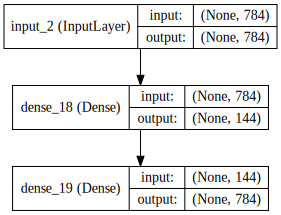

In [67]:
inputs = Input(shape=(input_unit_size,))
x = Dense(144, activation='relu')(inputs)
outputs = Dense(input_unit_size)(x)
model = Model(input=inputs, output=outputs)
model.compile(loss='mse', optimizer='adadelta')

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 7.3 学習

In [68]:
model.fit(X_train, X_train, nb_epoch=19, batch_size=256)

Epoch 1/19
7000/7000 [==============================] - 0s - loss: 0.1114     
Epoch 2/19
7000/7000 [==============================] - 0s - loss: 0.0838     
Epoch 3/19
7000/7000 [==============================] - 0s - loss: 0.0688     
Epoch 4/19
7000/7000 [==============================] - 0s - loss: 0.0648     
Epoch 5/19
7000/7000 [==============================] - 0s - loss: 0.0632     
Epoch 6/19
7000/7000 [==============================] - 0s - loss: 0.0620     
Epoch 7/19
7000/7000 [==============================] - 0s - loss: 0.0610     
Epoch 8/19
7000/7000 [==============================] - 0s - loss: 0.0599     
Epoch 9/19
7000/7000 [==============================] - 0s - loss: 0.0589     
Epoch 10/19
7000/7000 [==============================] - 0s - loss: 0.0577     
Epoch 11/19
7000/7000 [==============================] - 0s - loss: 0.0566     
Epoch 12/19
7000/7000 [==============================] - 0s - loss: 0.0554     
Epoch 13/19
7000/7000 [==========================

## 7.4 可視化
### 7.4.1 入力画像

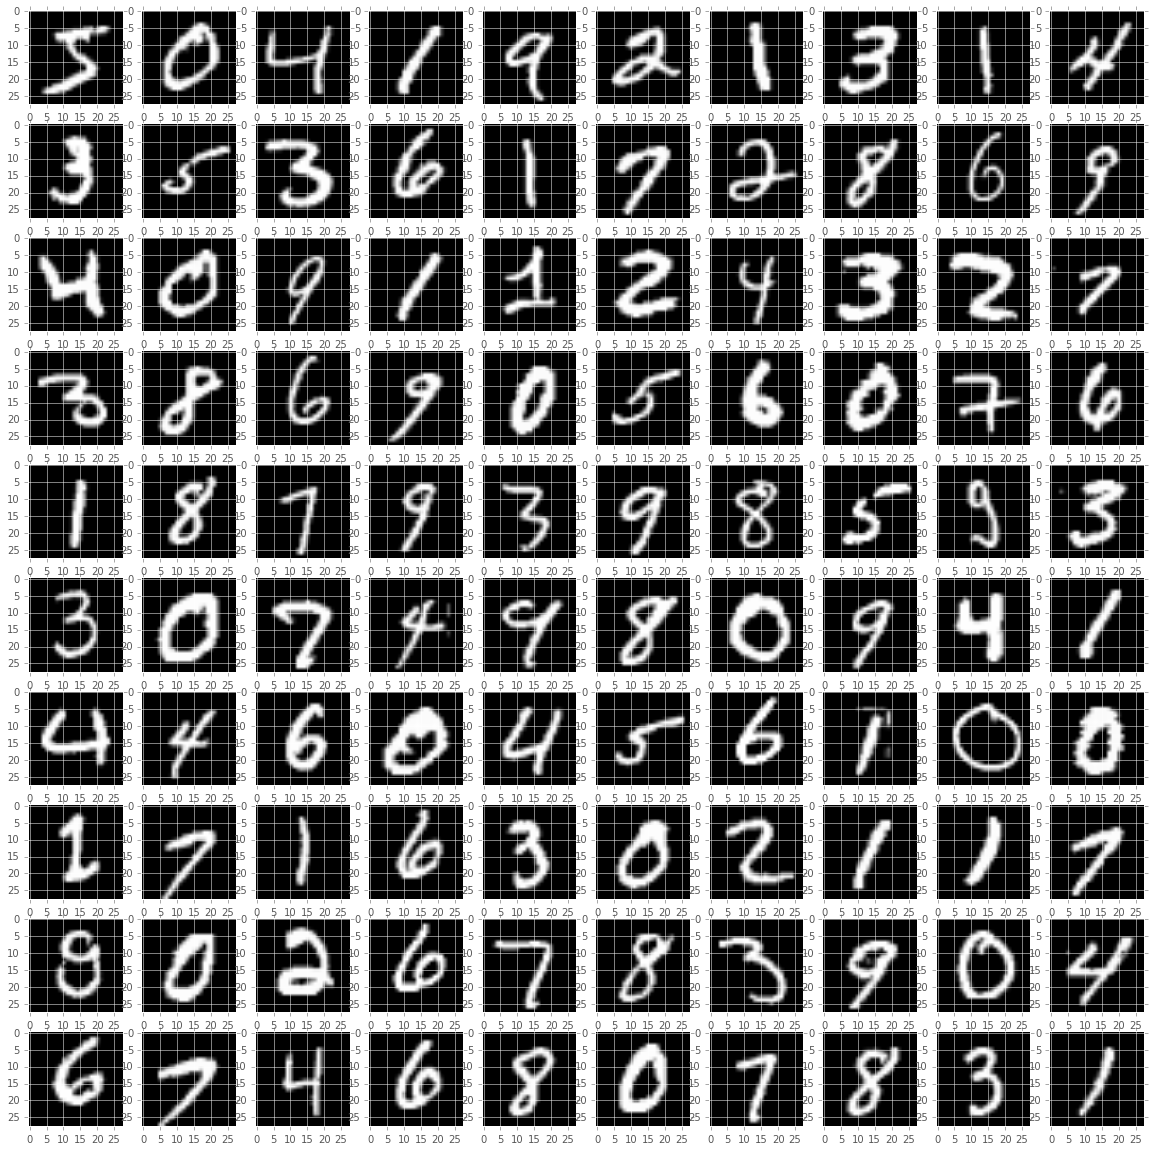

In [69]:
show_size = 10
total = 0
plt.figure(figsize=(20,20))
for i in range(show_size):
    for j in range(show_size):    
        draw_digit(X_train[total].reshape(28,28), show_size, show_size, total+1)
        total+=1
plt.show()

### 7.4.2 中間層

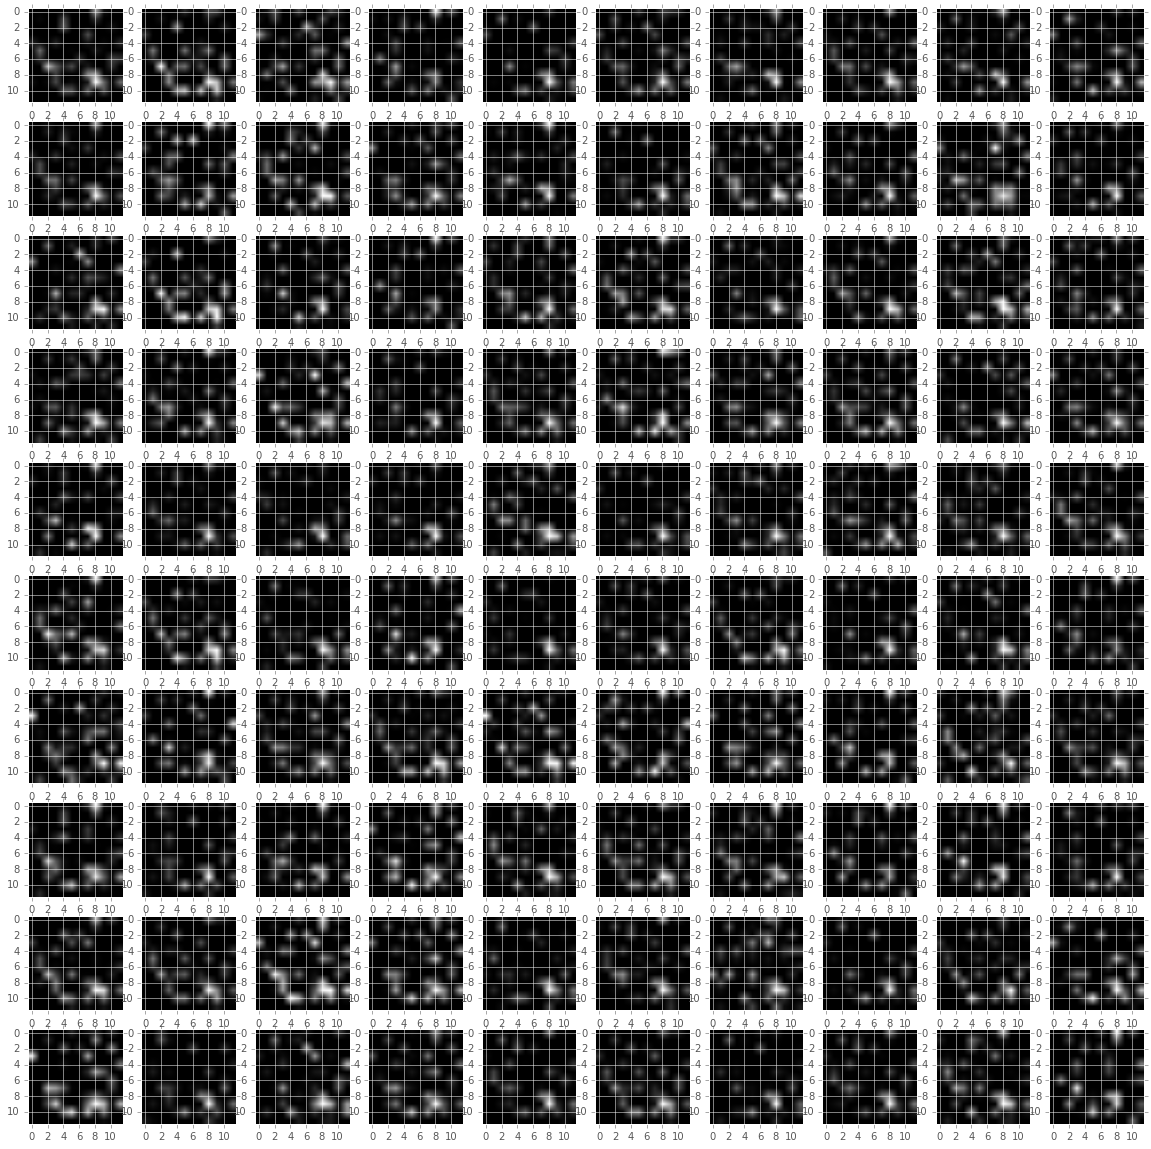

In [70]:
get_layer_output = K.function([model.layers[0].input],
                              [model.layers[1].output])

hidden_outputs = get_layer_output([X_train[0:show_size**2]])[0]

total = 0
plt.figure(figsize=(20,20))
for i in range(show_size):
    for j in range(show_size):    
        draw_digit(hidden_outputs[total].reshape(12, 12), show_size, show_size, total+1)
        total+=1
plt.show()

## 7.4.3 復元画像

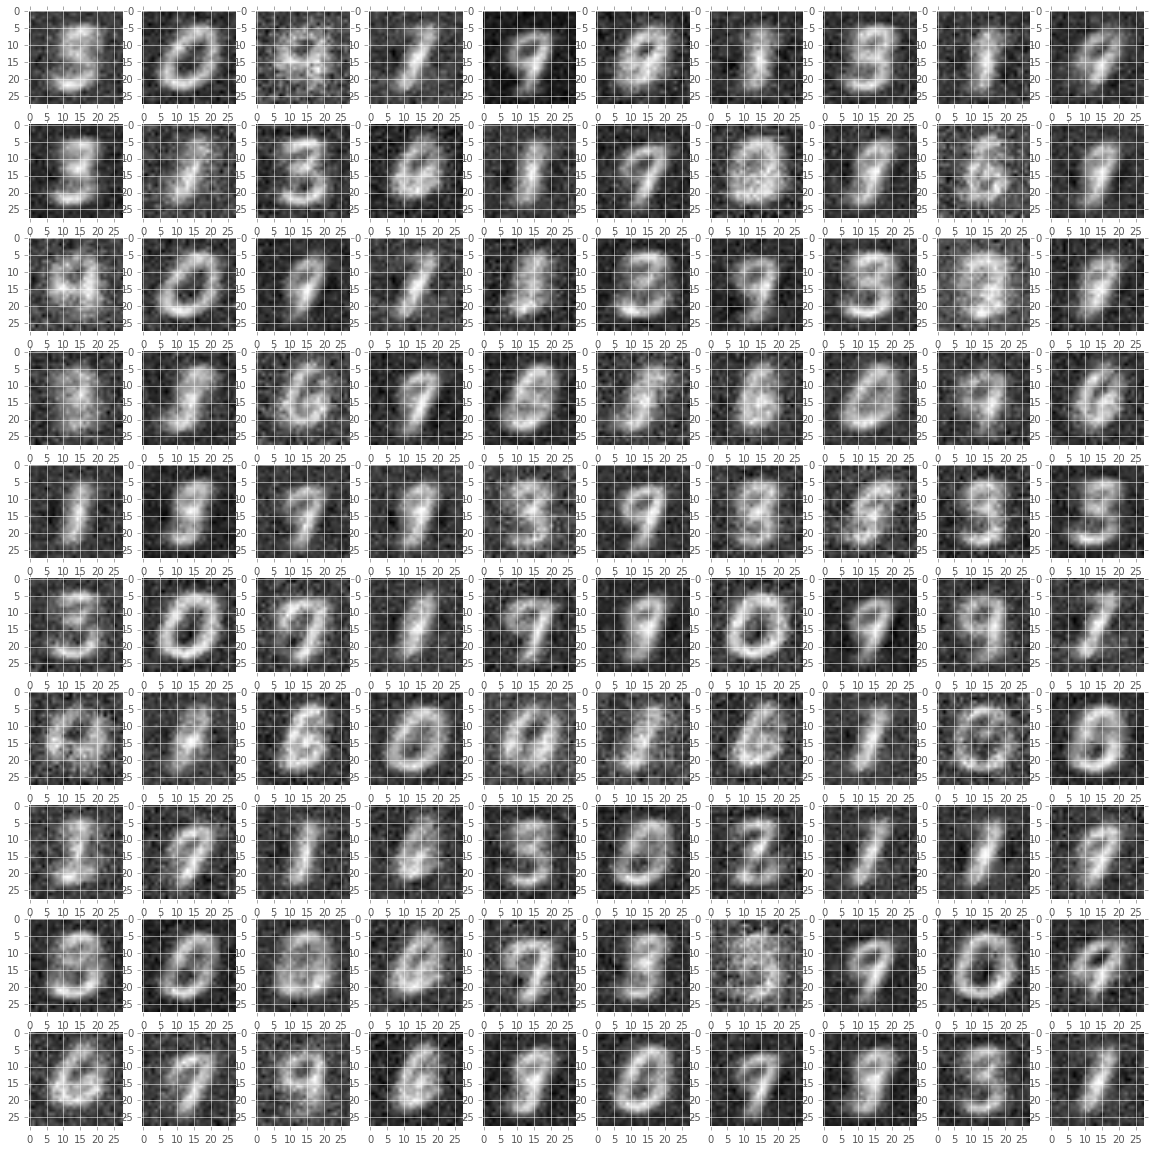

In [71]:
get_layer_output = K.function([model.layers[0].input],
                              [model.layers[2].output])

last_outputs = get_layer_output([X_train[0:show_size**2]])[0]

total = 0
plt.figure(figsize=(20,20))
for i in range(show_size):
    for j in range(show_size):    
        draw_digit(last_outputs[total].reshape(28, 28), show_size, show_size, total+1)
        total+=1
plt.show()

# 8. Continuous Bag of Words
word2vecで有名になったアルゴリズムの片方

ある単語の周囲の単語ベクトルを入力とし，注目している単語を予測するように学習を行います．

## 8.1 データ

_Alice's Adventures in Wonderland_ を使います．  

In [72]:
base_filter()
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
corpus = open(path).readlines()[0:500]
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters=base_filter()+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
V = len(tokenizer.word_index) + 1 # 語彙数
dim = 100 # ベクトルの次元
window_size = 2 # 文脈窓幅

In [73]:
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        contexts = []
        labels   = []
        L = len(words)
        for index, word in enumerate(words):
            s = index-window_size
            e = index+window_size+1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            y = np_utils.to_categorical(labels, V)
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            yield (x, y)
        

## 8.2 モデル定義

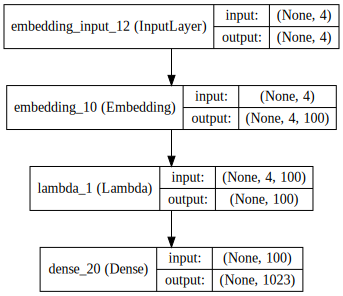

In [74]:
cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform',input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow.add(Dense(V, init='glorot_uniform', activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer="adadelta")
SVG(model_to_dot(cbow, show_shapes=True).create(prog='dot', format='svg'))

## 8.3 学習

In [75]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow.train_on_batch(x, y)
    print(ite, loss)

0 28432.1996384
1 24971.1928605
2 23023.7741524
3 21498.2474921
4 20270.641627
5 19247.0622016
6 18333.4240407
7 17502.0578976
8 16770.3190116
9 16126.2936538


## 8.4 単語ベクトルの保存

単語ベクトルを`gensim`で扱うものとして，オリジナルの`word2vec`の単語ベクトルと同じ形式で保存します．

In [76]:
f = open('vectors.txt' ,'w')
f.write(" ".join([str(V-1), str(dim)]))
f.write("\n")

vectors = cbow.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

## 8.5 word similarity
得られた単語ベクトルを元に単語間の類似度計算をしてみましょう．  
例として `alice`と近い単語集合を示します．

In [77]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [78]:
w2v.most_similar(positive=['alice'])

[('she', 0.6031362414360046),
 ('mouse', 0.519598126411438),
 ('words', 0.4961796998977661),
 ('come', 0.4896242618560791),
 ('either', 0.46657830476760864),
 ('a', 0.46163544058799744),
 ('we', 0.42980796098709106),
 ('taught', 0.42131510376930237),
 ('burnt', 0.41141557693481445),
 ('and', 0.41073933243751526)]

# 9. Skip Gram
word2vecで有名になったアルゴリズムのもう片方

1単語を入力とし，その周囲で共起する単語を予測するように学習を行います．  
negative-sampingや階層ソフトマックスは行いません．

## 9.1 データ

CBoWと同じく _Alice's Adventures in Wonderland_ を使います．  

In [17]:
base_filter()
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
corpus = open(path).readlines()[0:500]
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters=base_filter()+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
V = len(tokenizer.word_index) + 1 # 語彙数
dim = 100 # ベクトルの次元
window_size = 2 # 文脈窓幅

In [18]:
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            s = index-window_size
            e = index+window_size+1
                    
            in_words = []
            labels = []
            for i in range(s, e):
                if i != index and 0 <= i < L:
                    in_words.append([word] )
                    labels.append(words[i])

            x = np.array(in_words,dtype=np.int32)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

## 9.2 モデル定義

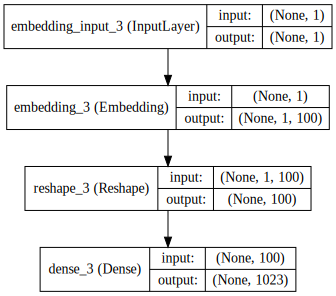

In [19]:
skipgram = Sequential()
skipgram.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim, )))
skipgram.add(Dense(input_dim=dim, output_dim=V, activation='softmax'))
skipgram.compile(loss='categorical_crossentropy', optimizer="adadelta")
SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg'))

## 9.3 学習

In [21]:
for ite in range(10):
    print(ite)
    for x, y in generate_data(corpus, window_size, V):
        skipgram.train_on_batch(x, y)

0
1
2
3
4
5
6
7
8
9


## 9.4 単語ベクトルの保存とword similarity

In [22]:
f = open('vectors.txt' ,'w')
f.write(" ".join([str(V-1),str(dim)]))
f.write("\n")

1

In [23]:
vectors = skipgram.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [24]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [36]:
w2v.most_similar(positive=['alice'])

[('begun', 0.3390645384788513),
 ('fallen', 0.33145636320114136),
 ('several', 0.31219980120658875),
 ('bad', 0.3085474371910095),
 ('yes', 0.30289405584335327),
 ('grand', 0.2968328595161438),
 ('anxiously', 0.29533815383911133),
 ('she', 0.29292380809783936),
 ('duck', 0.2897355556488037),
 ('noticed', 0.2748793959617615)]


## 10. リソース

知ってる範囲でkeras関連の情報を列挙します．

- http://keras.io/
- [日本語docs(作業が始まったばかり)](https://github.com/fchollet/keras-docs-ja)
- [blog](http://blog.keras.io/)
- slack
- [google group](https://groups.google.com/forum/#!forum/keras-users)
- [github](https://github.com/fchollet/keras)
- [examples](https://github.com/fchollet/keras/tree/master/examples)
- [youtube](https://www.youtube.com/results?search_query=keras+deep+learning)
